## Relating expo survey entrance data against terrain model


### Process the terrain data in Python2 into UTM33 tif images

This as a command line to warp into the same scheme in 10m cells
> gdalwarp -t_srs "+proj=utm +zone=33 +datum=wgs84 +spheroid=wgs84 +units=m" -tr 10 10 LiDARclipped.tif LiDARclippedwarped.tif

This makes no change to the numbers, but it sorts out the tif data
> gdalwarp -t_srs "+proj=utm +zone=33 +datum=wgs84 +spheroid=wgs84 +units=m" als_dgm_1m.txt als_dgm_1m.tif

Python2 code accesses the gdal library to write into csv with transform info that we load into pandas

```
import gdal

def tifftocsv(fname):
    r = gdal.Open(fname)
    s = r.GetRasterBand(1).ReadAsArray()
    print(r.GetProjection())
    print(r.GetGeoTransform())   # <---- this converts pixel coordinates into real coordinates
    fout = open(fname[:-3]+"csv", "w")
    for l in s:
        fout.write(",".join(map(str, l)))
        fout.write("\n")
    fout.close()
```

* tifftocsv("LiDARclippedwarped.tif")

(403788.8928663386, 10.0, 0.0, 5290093.737330623, 0.0, -10.0)

* tifftocsv("als_dgm_1m.tif")

(411099.5, 1.0, 0.0, 5283850.5, 0.0, -1.0)





In [268]:
rc = pandas.read_csv("LiDARclippedwarped.csv", header=None)
rc[rc==-32768.0] = 1000
print("shape", rc.shape, "height range", min(numpy.min(rc)), max(numpy.max(rc)))
rcgeotransform = (403788.8928663386, 10.0, 0.0, 5290093.737330623, 0.0, -10.0)

rt = pandas.read_csv("als_dgm_1m.csv", header=None)
rt[rt==-9999.0] = 1900
print("shape", rt.shape, "height range", min(numpy.min(rt)), max(numpy.max(rt)))
rtgeotransform = (411099.5, 1.0, 0.0, 5283850.5, 0.0, -1.0)



shape (2181, 1986) height range 500.0 2125.0
shape (1251, 801) height range 1685.54 1939.42


In [283]:
# elevation range of pixels and neighbours at particular coordinate system
def minmaxalt(r, rtransform, d, px, py):
    x, y = (px - rtransform[0])/rtransform[1], (py - rtransform[3])/rtransform[5] 
    y0, y1 = y-d, y+d+1
    x0, x1 = x-d, x+d+1
    if x0<0 or y0<0 or x1>r.shape[1] or y1>r.shape[0]:
        return numpy.nan
    r9 = r.iloc[int(y0):int(y1), int(x0):int(x1)]
    if (r9==1000).any().any():  # the nodata value
        return numpy.nan
    return (r9.min().min(), r9.max().max(), int(x), int(y))

# check that the entries line up between the terrain models

# then get the range around all the other *fix examples

#r = pandas.read_csv("als_dgm_1m.txt", decimal=',', header=None, skiprows=6, delim_whitespace=True)
#r = r.iloc[:-1,:-1]

In [319]:
import sys
sys.path.append("/home/julian/repos/groundwindow/")
import parse3ddmp   # julian's survex dmp parsing module
dmp3d = parse3ddmp.DMP3d(open("all.dmp").readlines())

rents = [ (name, p[0], p[1], p[2])  for p, name, flags in dmp3d.nodes  if "ENTRANCE" in flags ]
trents = [ ]
for name, px, py, alt in rents:
    w = (name, px, py, alt, minmaxalt(rc, rcgeotransform, 1, px, py), minmaxalt(rt, rtgeotransform, 1, px, py), dents.get(name))
    trents.append(w)
    

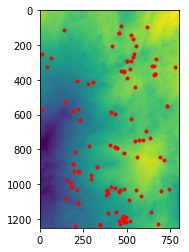

In [320]:

plt.imshow(rt, origin="upper")
strents = [t  for t in trents  if type(t[5]) == tuple ]
plt.plot([t[5][2]  for t in strents], [t[5][3]  for t in strents], "r.")


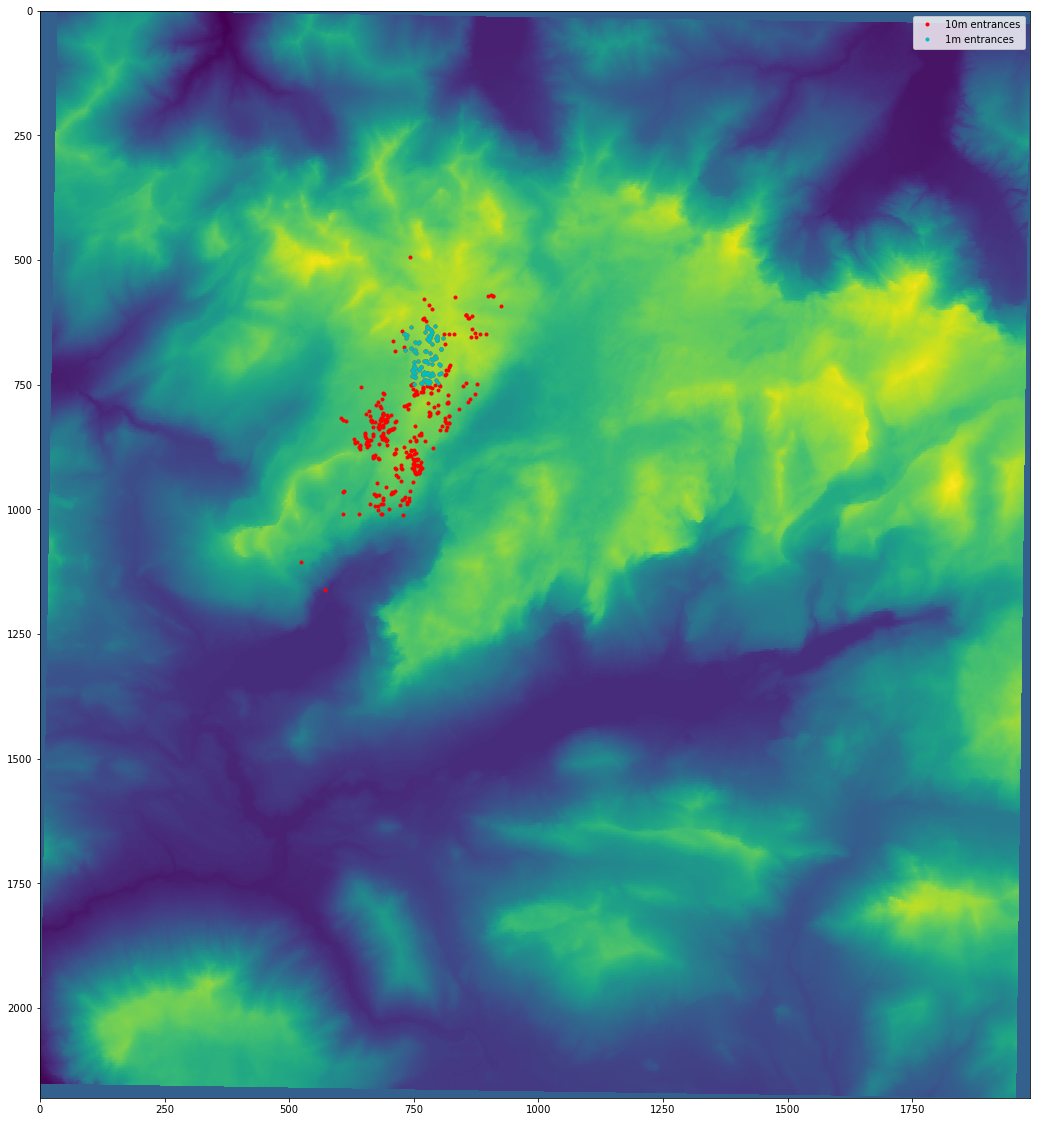

In [391]:
plt.figure(figsize=(20,20))
plt.imshow(rc, origin="upper")
plt.plot([t[4][2]  for t in trents], [t[4][3]  for t in trents], "r.", label="10m entrances")
plt.plot([t[4][2]  for t in strents], [t[4][3]  for t in strents], "c.", label="1m entrances")
plt.legend()

Number entrances in 10m area 398 average terrain survey difference 42.1891959799


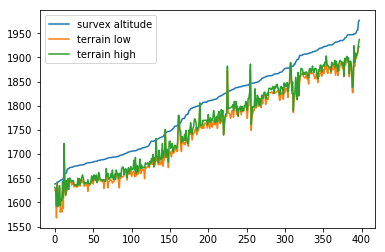

In [393]:
trents.sort(key=lambda X:X[3])
plt.plot([t[3]  for t in trents[10:-10]], label="survex altitude")
plt.plot([t[4][0]  for t in trents[10:-10]], label="terrain low")
plt.plot([t[4][1]  for t in trents[10:-10]], label="terrain high")
plt.legend()
s = [t[3] - (t[4][0]+t[4][1])/2  for t in trents[10:-10]]
print("Number entrances in 10m area", len(s), "average terrain survey difference", sum(s)/len(s))

Number entrances in 1m area 89 average terrain survey difference 40.2961797753


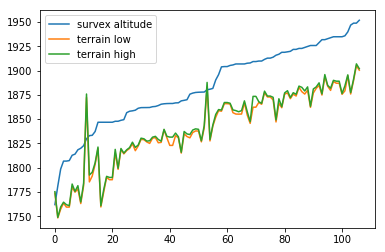

In [394]:
strents.sort(key=lambda X:X[3])
plt.plot([t[3]  for t in strents[1:-1]], label="survex altitude")
plt.plot([t[5][0]  for t in strents[1:-1]], label="terrain low")
plt.plot([t[5][1]  for t in strents[1:-1]], label="terrain high")
#plt.plot([t[4][0]  for t in strents[1:-1]])
#plt.plot([t[4][1]  for t in strents[1:-1]])
plt.legend()
s = [t[3] - (t[4][0]+t[4][1])/2  for t in strents[10:-10]]
print("Number entrances in 1m area", len(s), "average terrain survey difference", sum(s)/len(s))


In [396]:
# It seems that both the 1m and 10m elevation files have heights relative to the WGS84 ellipsoid
# while most of our entrance points are recorded to mean sea level/geoid altitude, which is a 
# default bodged calculation in cheap GPS devices where customers are going to complain that 
# they don't read zero when they are on the sea.  The correct answer is about +46.5311m in EMG96

## Section for changing *fixes

This code to scan through the \*fix files to look up the best altitude from the terrain model

Then rewrite them into the terrainfixedpts/ directory that runs as an alternative to the fixedpts/ directory
to see if it changes (improves!) the vertical error on all.svx


In [343]:
# check err file for vertical errors
import re
hs, vs = [], []
fin = open("/home/julian/data/expodata/loser/all.err")
for l in fin:
    ls = l.split()
    if len(ls) == 4 and ls[0] == "H:" and ls[2] == "V:":
        hs.append(float(ls[1]))
        vs.append(float(ls[3]))
len(hs), sum(hs), sum(vs)


(1453, 6269.213090000002, 3862.722899000006)

In [353]:
# now make a duplicate of the fixed points and rewrite the altitudes within them

import os
fd = "/home/julian/data/expodata/loser/tfixedpts"
fsvxs = [ os.path.join(fd, f)  for f in os.listdir(fd)  if f[-4:] == ".svx" ]
fd = os.path.join(fd, "gps")
fsvxs.extend([ os.path.join(fd, f)  for f in os.listdir(fd)  if f[-4:] == ".svx" ])


In [361]:
s = fsvxs[0]
ls = open(s, "rb").readlines()


In [384]:
import re
allfixes = [ ]
for s in fsvxs:
    if s[-8:] == "ents.svx":
        continue
    ls = open(s, "rb").readlines()
    for i in range(len(ls)):
        try:
            dl = ls[i].decode("utf8")
        except UnicodeDecodeError:
            continue
        ml = re.match("(?i)\s*\*fix\s+(\S+)\s*(reference)?\s+(\S+)\s+(\S+)\s+(\S+)", dl)
        if ml:
            allfixes.append(ml.groups())
        
    

In [388]:
# The "reference" condition is often misused for fixed points that are anyway connected in, 
[(float(a[2]), float(a[3])+5200000)  for a in allfixes  if not a[1]]


[(36616.0, 5285002.0),
 (37977.26, 5285459.75),
 (38145.23, 5285275.55),
 (37935.37, 5285490.35),
 (36711.0, 5285264.0),
 (36604.0, 5285387.0),
 (36645.0, 5284933.0),
 (36831.0, 5284836.0),
 (36227.0, 5284668.0),
 (37226.0, 5285423.0),
 (36389.0, 5281375.6),
 (36353.0, 5284807.0),
 (36595.0, 5284981.0),
 (36292.0, 5286213.0),
 (36013.0, 5281335.0),
 (35869.0, 5281380.0),
 (35865.0, 5281341.0),
 (36141.0, 5281804.0),
 (37132.0, 5284031.0),
 (36920.0, 5284087.0),
 (36946.0, 5283663.0),
 (36960.0, 5283654.0),
 (36849.0, 5283231.0),
 (37485.85, 5283709.75)]